### Importação das Bibliotecas

In [42]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from scikeras.wrappers import KerasRegressor

from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.metrics import RootMeanSquaredError

In [43]:
def create_sequences_mult(X, y, seq_len=14):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])   
        ys.append(y[i+seq_len])    
    return np.array(Xs), np.array(ys)

In [44]:
def create_lstm_model(seq_len=14, n_features=1, neurons=100, drop=0.2, optimizer='Adam'):
  model = Sequential([
      Input(shape=(seq_len, n_features)),
      LSTM(neurons, return_sequences=True),
      Dropout(drop),
      LSTM((neurons//2), return_sequences=False),
      Dropout(drop),
      Dense(1),
  ])
  model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
  return model


param_grid = {
                # 'model__neurons': [16, 32, 64],
                # 'model__drop': [0.2, 0.25, 0.3],
                # 'model__optimizer': ['Adam'], 
                # 'fit__batch_size': [16, 32],   
                # 'fit__epochs': [50, 100],
                'model__neurons': [80],
                'model__drop': [0.1],
                'model__optimizer': ['Adam'], 
                'fit__batch_size': [16],   
                'fit__epochs': [100],
              }

In [45]:
models_lstm_all = []
models_lstm_cropped = []
# seq_len_options = [7, 14, 30]
seq_len_options = [7]
# split_options = [5, 10]
split_options = [5]


event_date = pd.Timestamp('2024-11-05') 
event_label = "Trump Elected"

### Modelo com dado completo

In [46]:
data = pd.read_csv('../data/processed/BTC-USD_all.csv', index_col='Date', parse_dates=True)
data.head(5)

,Close,High,Low,Open,Volume
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


In [47]:
X_mult = data[['High', 'Low', 'Open', 'Volume']]
y_mult = data[['Close']]

scaler_X_all = MinMaxScaler(feature_range=(0,1))
scaler_y_all = MinMaxScaler(feature_range=(0,1))

X_mult_scaled = scaler_X_all.fit_transform(X_mult)
y_mult_scaled = scaler_y_all.fit_transform(y_mult)

In [48]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_seq, y_seq = create_sequences_mult(X_mult_scaled, y_mult_scaled, seq_len)

  train_size = int(0.8 * len(X_seq))

  X_train_scaled, X_test_scaled = X_seq[:train_size], X_seq[train_size:]
  y_train_scaled, y_test_scaled = y_seq[:train_size], y_seq[train_size:]

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)

    grid_result_all = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm_all.append({
      "params": grid_result_all.best_params_,
      "rmse": -grid_result_all.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "type": "Multivariado",
      "algorithm": "LSTM"
    })
    
    print(f"Menor RMSE: {-grid_result_all.best_score_:.3f} usando: {grid_result_all.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.010 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 80, 'model__optimizer': 'Adam'}


#### Resultados e Discussão

Nesta seção são apresentados e discutidos os resultados obtidos pelo modelo.
Comente sobre o desempenho de cada configuração de parâmetros e interprete as métricas.  
Apresente também comparações gráficas entre valores reais e previstos.


In [49]:
ordered_models = sorted(models_lstm_all, key=lambda x: x["rmse"])
ordered_models

[{'params': {'fit__batch_size': 16,
   'fit__epochs': 100,
   'model__drop': 0.1,
   'model__neurons': 80,
   'model__optimizer': 'Adam'},
  'rmse': np.float64(0.009544679823652076),
  'n_splits': 5,
  'seq_len': 7,
  'type': 'Multivariado',
  'algorithm': 'LSTM'}]

In [50]:
grid_result_all.best_estimator_

,model,<function cre...001F4446460C0>
,build_fn,None
,warm_start,False
,random_state,None
,optimizer,'rmsprop'
,loss,None
,metrics,None
,batch_size,None
,validation_batch_size,None
,verbose,0
,callbacks,None


In [51]:
y_pred_scaled = grid_result_all.best_estimator_.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred_scaled))
mae = mean_absolute_error(y_test_scaled, y_pred_scaled)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

y_pred = scaler_y_all.inverse_transform(y_pred_scaled)
y_test = scaler_y_all.inverse_transform(y_test_scaled)


MAE: 0.04052234370870875
RMSE: 0.05291911212806932


In [52]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE(%): {mape:.2f}%")
print(f"R²: {r2:.2f}")

MAE: 5048.049156057099
RMSE: 6592.36941763332
MAPE(%): 5.73%
R²: 0.95


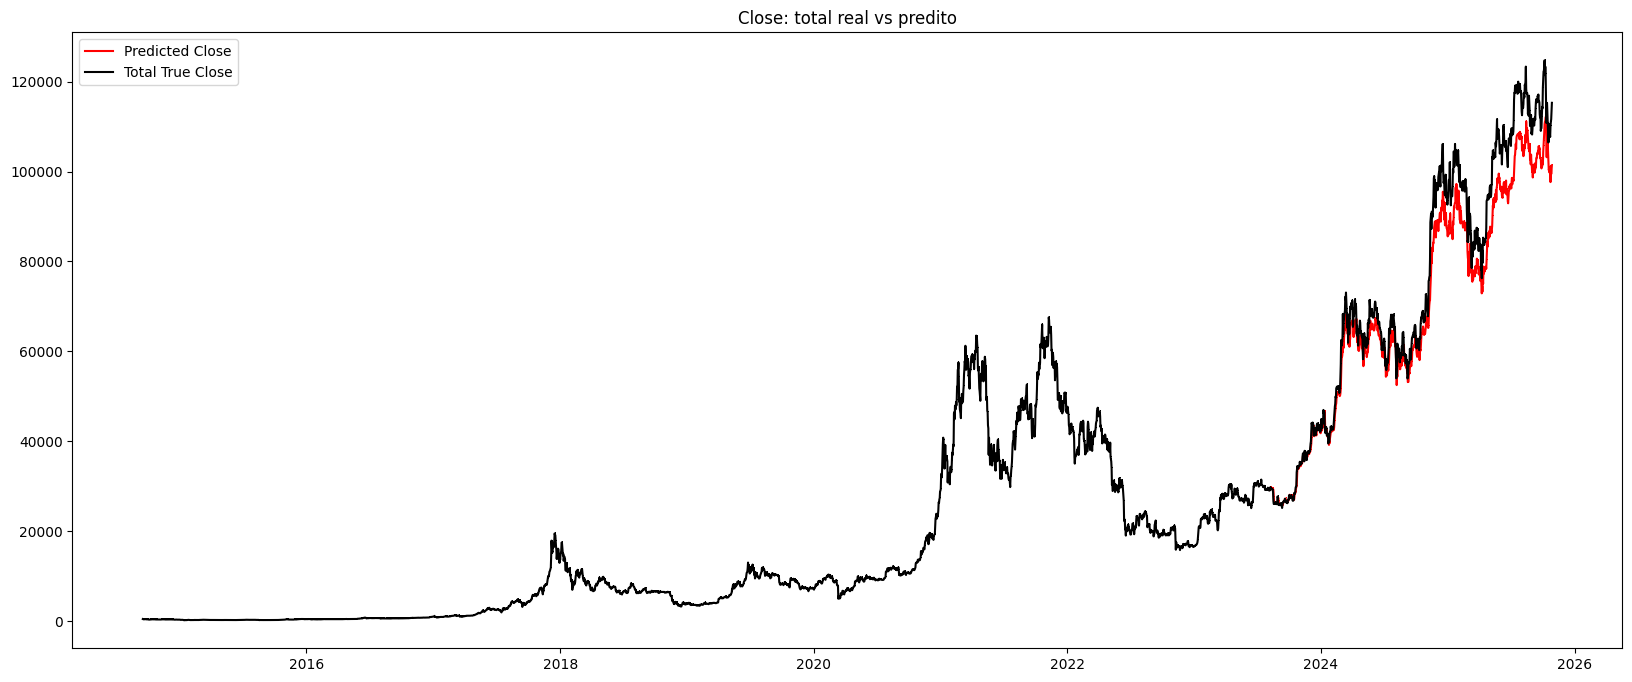

In [53]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

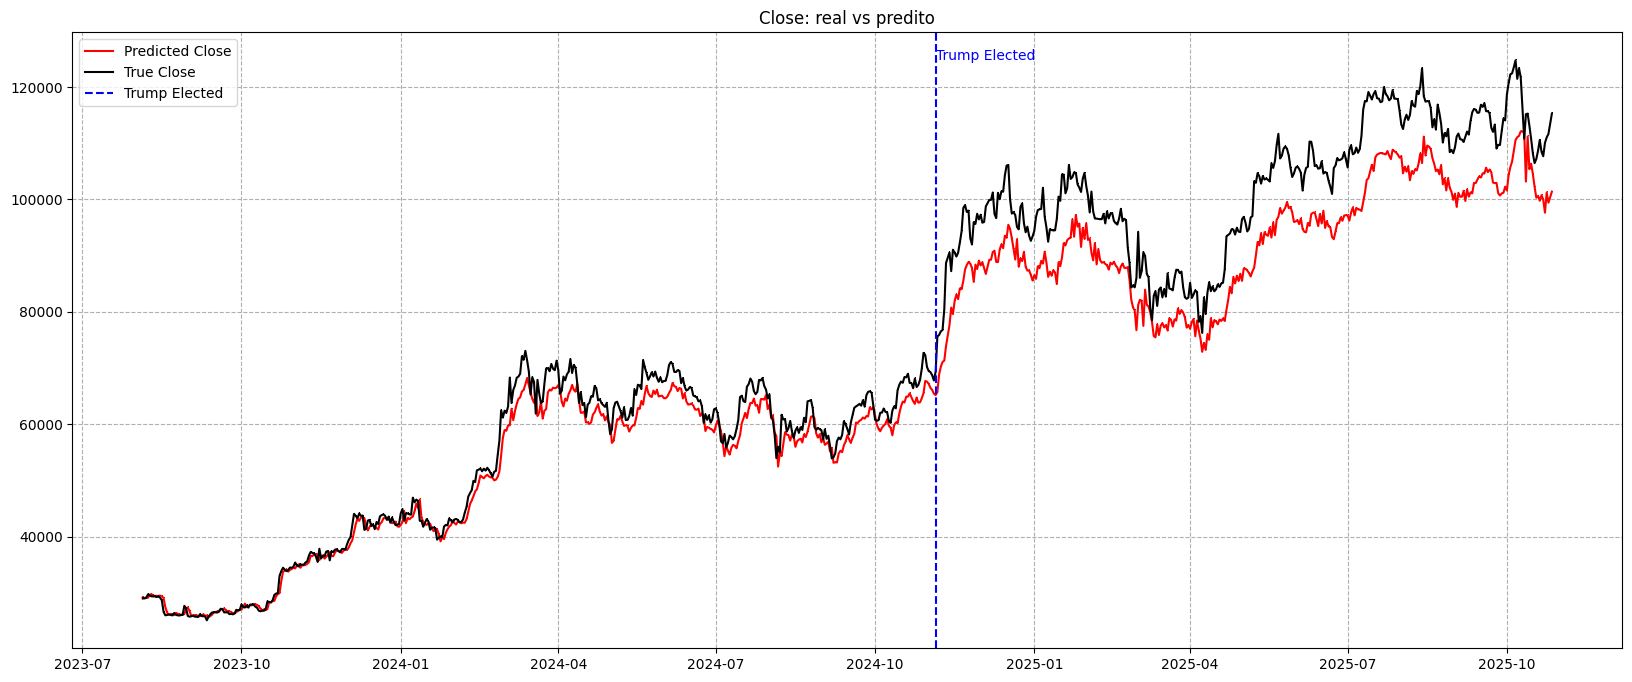

In [54]:
plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
plt.axvline(x=event_date, color='blue', linestyle='--', label=event_label)
plt.text(event_date, max(data['Close']), event_label, color='blue')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()

### Modelo com dado cortado (inicio ate a moeda se estabilizar foi removido)

In [55]:
data = pd.read_csv('../data/processed/BTC-USD_cropped.csv', index_col='Date', parse_dates=True)
data.head(5)

,Close,High,Low,Open,Volume
Date,,,,,
2017-01-01,998.325012,1003.080017,958.698975,963.658020,147775008
2017-01-02,1021.750000,1031.390015,996.702026,998.617004,222184992
2017-01-03,1043.839966,1044.079956,1021.599976,1021.599976,185168000
2017-01-04,1154.729980,1159.420044,1044.400024,1044.400024,344945984
2017-01-05,1013.380005,1191.099976,910.416992,1156.729980,510199008


In [56]:
X_mult = data[['High', 'Low', 'Open', 'Volume']]
y_mult = data[['Close']]

scaler_X_cropped = MinMaxScaler(feature_range=(0,1))
scaler_y_cropped = MinMaxScaler(feature_range=(0,1))

X_mult_scaled = scaler_X_cropped.fit_transform(X_mult)
y_mult_scaled = scaler_y_cropped.fit_transform(y_mult)

In [57]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_seq, y_seq = create_sequences_mult(X_mult_scaled, y_mult_scaled, seq_len)

  train_size = int(0.8 * len(X_seq))

  X_train_scaled, X_test_scaled = X_seq[:train_size], X_seq[train_size:]
  y_train_scaled, y_test_scaled = y_seq[:train_size], y_seq[train_size:]

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)

    grid_result_cropped = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm_cropped.append({
      "params": grid_result_cropped.best_params_,
      "rmse": -grid_result_cropped.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "type": "Multivariado",
      "algorithm": "LSTM"
    })
    
    print(f"Menor RMSE: {-grid_result_cropped.best_score_:.3f} usando: {grid_result_cropped.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.015 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 80, 'model__optimizer': 'Adam'}


#### Resultados e Discussão

Nesta seção são apresentados e discutidos os resultados obtidos pelo modelo.
Comente sobre o desempenho de cada configuração de parâmetros e interprete as métricas.  
Apresente também comparações gráficas entre valores reais e previstos.


In [58]:
ordered_models = sorted(models_lstm_cropped, key=lambda x: x["rmse"])
ordered_models

[{'params': {'fit__batch_size': 16,
   'fit__epochs': 100,
   'model__drop': 0.1,
   'model__neurons': 80,
   'model__optimizer': 'Adam'},
  'rmse': np.float64(0.014666409858022079),
  'n_splits': 5,
  'seq_len': 7,
  'type': 'Multivariado',
  'algorithm': 'LSTM'}]

In [59]:
grid_result_cropped.best_estimator_

,model,<function cre...001F4446460C0>
,build_fn,None
,warm_start,False
,random_state,None
,optimizer,'rmsprop'
,loss,None
,metrics,None
,batch_size,None
,validation_batch_size,None
,verbose,0
,callbacks,None


In [60]:
y_pred_scaled = grid_result_cropped.best_estimator_.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred_scaled))
mae = mean_absolute_error(y_test_scaled, y_pred_scaled)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

y_pred = scaler_y_cropped.inverse_transform(y_pred_scaled)
y_test = scaler_y_cropped.inverse_transform(y_test_scaled)

MAE: 0.03340334209224267
RMSE: 0.044852817576003914


In [61]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE(%): {mape:.2f}%")
print(f"R²: {r2:.2f}")

MAE: 4141.1719358450155
RMSE: 5560.618001998505
MAPE(%): 4.77%
R²: 0.94


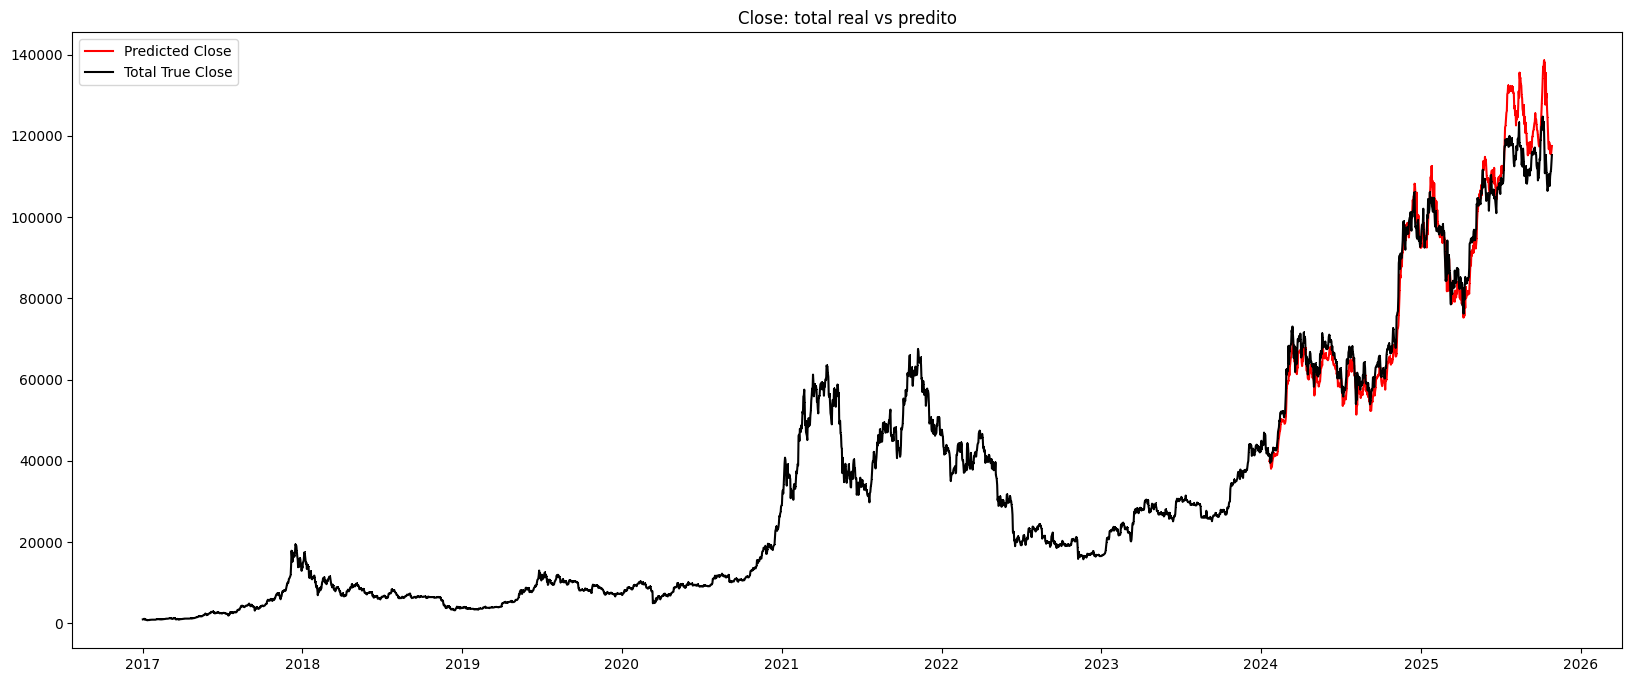

In [62]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

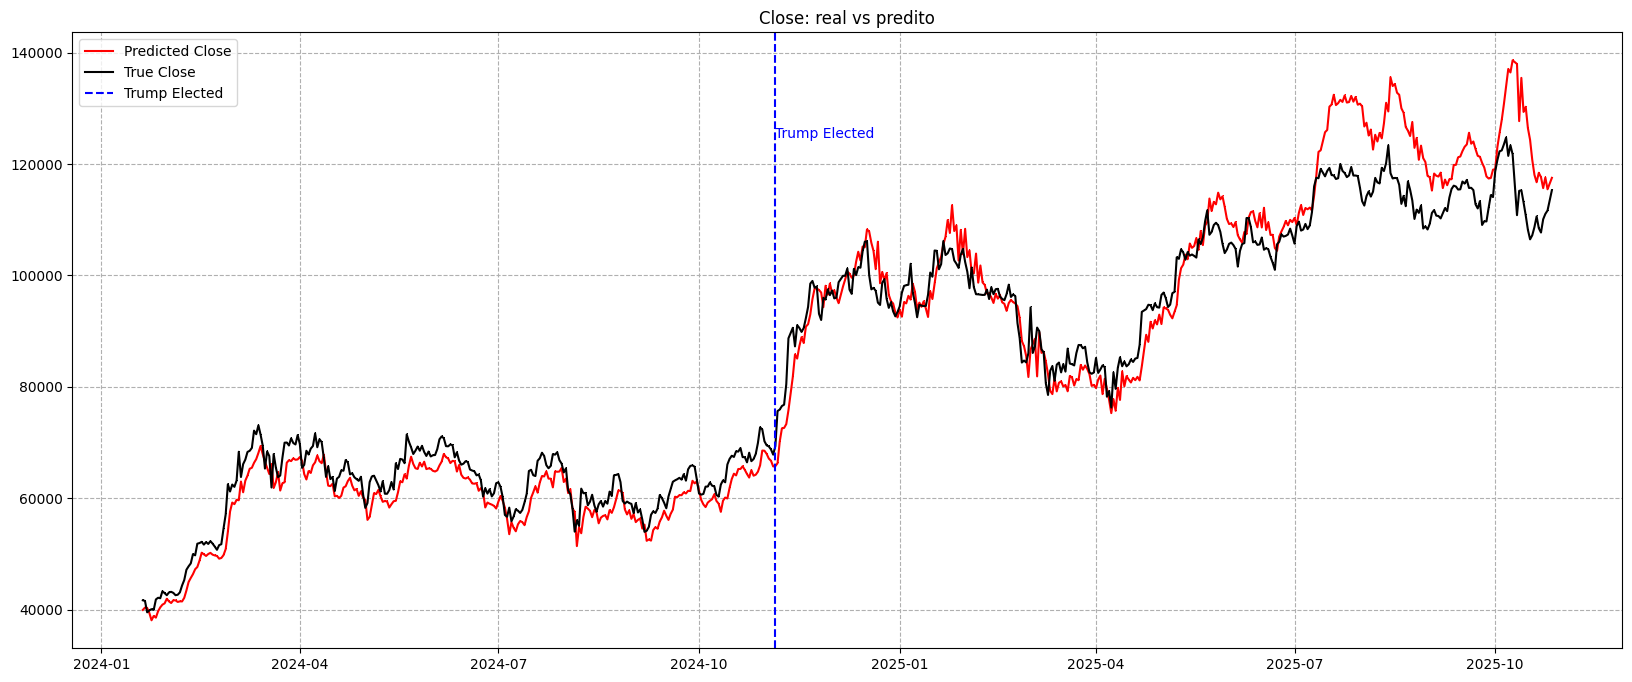

In [63]:

plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
plt.axvline(x=event_date, color='blue', linestyle='--', label=event_label)
plt.text(event_date, max(data['Close']), event_label, color='blue')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()

5 de novembro donald trump foi eleito presidente